In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AI/.kaggle/"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/AI/.kaggle

/content/drive/MyDrive/AI/.kaggle


In [ ]:
!kaggle datasets download -d mariafrenti/age-prediction

100% 2.03G/2.03G [01:20<00:00, 32.4MB/s]
100% 2.03G/2.03G [01:20<00:00, 27.2MB/s]


In [ ]:
!unzip age-prediction.zip
!ls

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: age_prediction_up/age_prediction/train/070/79502.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79589.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79660.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79733.jpg  
  inflating: age_prediction_up/age_prediction/train/070/79774.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80028.jpg  
  inflating: age_prediction_up/age_prediction/train/070/80607.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81012.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81131.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81329.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81604.jpg  
  inflating: age_prediction_up/age_prediction/train/070/81811.jpg  
  inflating: age_prediction_up/age_prediction/train/070/82005.jpg  
  inflating: age_prediction_up/age_prediction/train/070/82162.jpg  
  inflating:

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [3]:
# image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50') #tell python in which directory the training images are.
image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50')

In [4]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int32)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [10]:
images

,Filepath,Age
0,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,33
1,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,25
2,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,21
3,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,32
4,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,25
...,...,...
23990,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,23
23991,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,29
23992,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,42
23993,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,24


In [5]:
image_df = images.sample(20000, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_df

,Filepath,Age
11408,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,22
3616,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,27
9747,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,32
6915,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,24
4888,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,33
...,...,...
10955,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,30
17289,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,24
5192,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,34
12172,/content/drive/MyDrive/AI/.kaggle/20-50/20-50/...,27


In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', # kepek
    y_col='Age', # becsülendő életkorok
    target_size=(120, 120), # egy kép mérete
    color_mode='rgb', # 3 csatornás képek, RGB
    class_mode='raw', # mivel a célváltozónk int típusú és nem object
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 11200 validated image filenames.
Found 2800 validated image filenames.
Found 6000 validated image filenames.


In [9]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
350/350 [==============================] - 5889s 17s/step - loss: 142.7845 - val_loss: 51.8563
Epoch 2/100
350/350 [==============================] - 36s 102ms/step - loss: 49.3573 - val_loss: 49.6876
Epoch 3/100
350/350 [==============================] - 36s 102ms/step - loss: 49.5718 - val_loss: 51.1436
Epoch 4/100
350/350 [==============================] - 35s 101ms/step - loss: 49.7907 - val_loss: 49.8790
Epoch 5/100
350/350 [==============================] - 39s 112ms/step - loss: 49.8205 - val_loss: 51.1152
Epoch 6/100
350/350 [==============================] - 35s 100ms/step - loss: 50.1381 - val_loss: 49.8060
Epoch 7/100
350/350 [==============================] - 36s 102ms/step - loss: 49.3180 - val_loss: 50.9643


In [11]:
predicted_ages = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

188/188 [==============================] - 2487s 13s/step
     Test RMSE: 6.96274
Test R^2 Score: -0.01005


In [12]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 6.92800


1/1 [==============================] - 0s 21ms/step


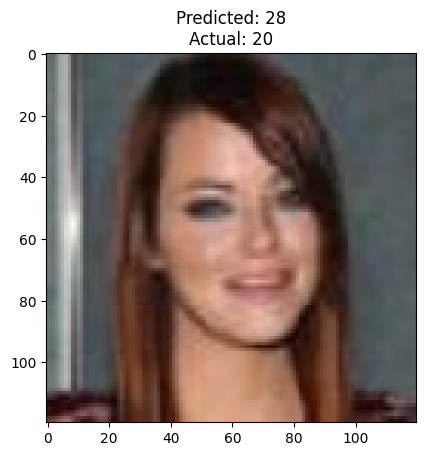

In [17]:
import matplotlib.pyplot as plt

test_image = '/content/drive/MyDrive/AI/.kaggle/20-50/20-50/test/20/42331.jpg'
image = tf.keras.preprocessing.image.load_img(test_image, target_size=(120,120))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = model.predict(input_arr)

plt.figure()
plt.imshow(image)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = images['Age'][images[images['Filepath'] == test_image].index.values[0]].astype(str)

plt.title('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age)

plt.show()